In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import numpy as np
import os
import pickle
import pyaudio
import wave
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import deque
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join('..', 'vap_sound/src')))

from utils.save_load_model import save_model_pickle, load_model_pickle
from utils.evaluate_model import evaluate_model

MODEL_PATH = "../model/vapor_model.pkl"
LOG_MODEL_EVALUATION = "../logs/model_evaluation.log"
LOG_MODEL_PREDICTION = "../logs/model_prediction.log"


In [ ]:
import torchaudio
import torchaudio.transforms as T
import torch
import pandas as pd
from speechbrain.pretrained import VAD

# Load pre-trained SpeechBrain VAD
vad_model = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="tmp_vad")

def extract_mfcc_features(audio_files, target_sample_rate=16000, future_offset=10, n_mfcc = 40):
    mfcc_transform = T.MFCC(sample_rate=target_sample_rate, n_mfcc=40, 
                            melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40})

    data_list = []

    for file in audio_files:
        # Load audio file
        waveform, sr = torchaudio.load(file)

        # Ensure the audio is in the correct sample rate (16kHz for VAD)
        if sr != target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sample_rate)
            waveform = resampler(waveform)

        # Convert the waveform to float32 (as required by VAD model)
        waveform = waveform.float()

        # Extract MFCC features
        mfcc = mfcc_transform(waveform)  # Shape: (channel, n_mfcc, time_steps)
        mfcc = mfcc.squeeze(0).T  # Remove channel dim and transpose to (time_steps, n_mfcc)

        # Add batch dimension (1, num_samples) for VAD input
        waveform = waveform.unsqueeze(0)  # Shape: (1, channel, num_samples)

        # Get the speech probability scores from the VAD model
        # tensor of shape (batch, num_samples)
        speech_probs = vad_model.get_speech_prob_chunk(waveform.squeeze(0))  # Shape: (time_steps,)

        # Ensure speech_probs is a tensor and squeeze it to (time_steps,)
        speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)

        # Apply threshold to convert probabilities to binary labels
        binary_labels = (speech_probs > 0.5).float()  # 1 if > 0.5, else 0

        # print(f"MFCC shape: {mfcc.shape}, Binary Labels shape: {binary_labels.shape}")

        # Align MFCC and binary labels
        min_length = min(mfcc.shape[0], binary_labels.shape[0])
        if min_length == 0:
            continue  # Skip empty entries

        mfcc = mfcc[:min_length, :]  # Truncate to min_length
        binary_labels = binary_labels[:min_length]  # Truncate to min_length

        # Future projection for next `future_offset` steps
        y_projected = torch.zeros_like(binary_labels)
        if min_length > future_offset:
            y_projected[:-future_offset] = binary_labels[future_offset:]
        else:
            y_projected = binary_labels  # If not enough steps, just use original

        data_list.append([mfcc.tolist(), y_projected.tolist()])

    df = pd.DataFrame(data_list, columns=['features', 'labels'])
    return df

# Test with the MP3 file
# a = extract_features_to_csv(['/Users/shanujha/Desktop/voice_activity_prediction/voice_data_mozilla/en/clips/common_voice_en_41247165.mp3'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:5: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import VAD
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/vad-crdnn-libriparty' 

In [ ]:
## Model definition

import torch
import torch.nn as nn

# Model
class VAPModel(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=128, lstm_hidden_dim=256, num_heads=8, num_layers=4, output_dim=1):
        super(VAPModel, self).__init__()
        
        # Transformer layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads),
            num_layers=num_layers
        )
        
        # LSTM Layer 
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, batch_first=True)
        
        # Fully connected layer to produce final output
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.transformer(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Collating data for training  --> Input is Pandas DataFrame
class VAPDataset(Dataset):
    def __init__(self, data_df, seq_length=100):
        # if isinstance(csv_files, str):
        #     csv_files = [csv_files]
        
        self.seq_length = seq_length
        # self.data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
        self.features = [torch.tensor(f) for f in data_df['features']]
        self.labels = [torch.tensor(l) for l in data_df['labels']]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        if feature.shape[0] > self.seq_length:
            feature = feature[-self.seq_length:]
            label = label[-self.seq_length:]
        else:
            pad_length = self.seq_length - feature.shape[0]
            feature = torch.cat([torch.zeros(pad_length, feature.shape[1]), feature], dim=0)
            label = torch.cat([torch.zeros(pad_length, label.shape[1]), label], dim=0)
        
        return feature, label

In [8]:
# Collate function to pad variable-length sequences
def collate_fn(batch):
    features, labels = zip(*batch)
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    return features_padded, labels_padded

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming VAPModel is your model class
class VAPModel(nn.Module):
    def __init__(self):
        super(VAPModel, self).__init__()
        # Define your model architecture here
        self.rnn = nn.GRU(input_size=40, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass
        out, _ = self.rnn(x)  # RNN output
        out = self.fc(out)  # Fully connected layer
        out = self.sigmoid(out)  # Sigmoid activation
        return out

# Training function
def train_model(model, training_data, batch_size=16, epochs=10, seq_length=100):
    """
    Train the model using the provided training data.

    Args:
        model (nn.Module): The model to train.
        training_data (pd.DataFrame): DataFrame containing 'features' and 'labels' columns.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        seq_length (int): Fixed sequence length for padding/truncation.
    """
    if os.path.exists(MODEL_PATH):
                model = load_model_pickle(path=MODEL_PATH)
    # Create dataset and dataloader
    train_dataset = VAPDataset(training_data, seq_length=seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0

        # Training phase
        for features, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)  # Shape: (batch_size, seq_length, 1)

            # Ensure labels have the same shape as outputs
            if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
            elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                pass  # Do nothing
            else:
                raise ValueError(f"Unexpected labels shape: {labels.shape}")

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase (using the same data for simplicity)
        model.eval()
        with torch.no_grad():
            for features, labels in train_loader:
                outputs = model(features)

                # Ensure labels have the same shape as outputs
                if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                    labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
                elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                    pass  # Do nothing
                else:
                    raise ValueError(f"Unexpected labels shape: {labels.shape}")

                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Log training and validation loss
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(train_loader):.4f}")
    save_model_pickle(model, path=MODEL_PATH)
    print("Training complete!")


In [10]:
from glob import glob
import os
import pandas as pd

data_dir = "/Users/shanujha/Desktop/voice_activity_prediction/voice_data_mozilla/en/clips"
audio_files = glob(os.path.join(data_dir, "*.mp3"))


CSV_FILE_PATH = "/Users/shanujha/Desktop/voice_activity_prediction/logs/trained_mp3_files.csv"


data = {"file_paths": audio_files, "processed": [0 for i in range(len(audio_files))]}
file_df = pd.DataFrame(data)
# csv_df.to_csv(CSV_FILE_PATH, index=False)

# file_df = pd.read_csv(CSV_FILE_PATH)

/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Epoch 1/10, Train Loss: 0.4578, Val Loss: 0.3860
Epoch 2/10, Train Loss: 0.4006, Val Loss: 0.3640
Epoch 3/10, Train Loss: 0.3680, Val Loss: 0.3913
Epoch 4/10, Train Loss: 0.3460, Val Loss: 0.3177
Epoch 5/10, Train Loss: 0.3233, Val Loss: 0.3178
Epoch 6/10, Train Loss: 0.3065, Val Loss: 0.2862
Epoch 7/10, Train Loss: 0.2776, Val Loss: 0.2431
Epoch 8/10, Train Loss: 0.2613, Val Loss: 0.2436
Epoch 9/10, Train Loss: 0.2535, Val Loss: 0.2391
Epoch 10/10, Train Loss: 0.2340, Val Loss: 0.2228
Model saved successfully as pickle file!
Training complete!


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Test Accuracy: 0.8166
Confusion Matrix:
[[14592  1572]
 [ 3929  9907]]


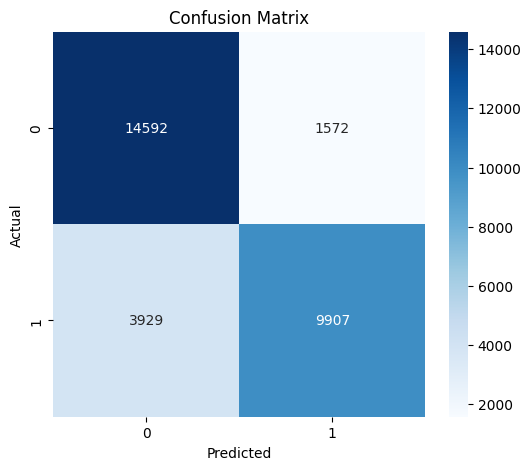

BATCH 2 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4152, Val Loss: 0.3469
Epoch 2/10, Train Loss: 0.3465, Val Loss: 0.3108
Epoch 3/10, Train Loss: 0.3203, Val Loss: 0.3128
Epoch 4/10, Train Loss: 0.2954, Val Loss: 0.2743
Epoch 5/10, Train Loss: 0.2774, Val Loss: 0.2346
Epoch 6/10, Train Loss: 0.2469, Val Loss: 0.2380
Epoch 7/10, Train Loss: 0.2534, Val Loss: 0.2275
Epoch 8/10, Train Loss: 0.2272, Val Loss: 0.1919
Epoch 9/10, Train Loss: 0.2025, Val Loss: 0.1859
Epoch 10/10, Train Loss: 0.1997, Val Loss: 0.1941
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8326
Confusion Matrix:
[[15766  1380]
 [ 3642  9212]]


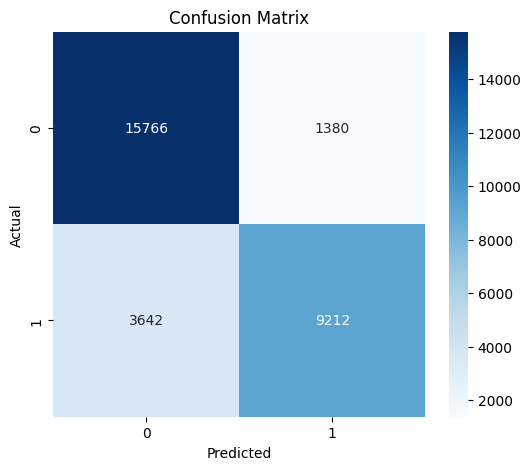

BATCH 3 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4132, Val Loss: 0.3356
Epoch 2/10, Train Loss: 0.3367, Val Loss: 0.2976
Epoch 3/10, Train Loss: 0.3069, Val Loss: 0.2929
Epoch 4/10, Train Loss: 0.2852, Val Loss: 0.2640
Epoch 5/10, Train Loss: 0.2548, Val Loss: 0.2413
Epoch 6/10, Train Loss: 0.2480, Val Loss: 0.2106
Epoch 7/10, Train Loss: 0.2351, Val Loss: 0.2264
Epoch 8/10, Train Loss: 0.2179, Val Loss: 0.1927
Epoch 9/10, Train Loss: 0.2062, Val Loss: 0.1781
Epoch 10/10, Train Loss: 0.1939, Val Loss: 0.1708
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8401
Confusion Matrix:
[[16292  1291]
 [ 3505  8912]]


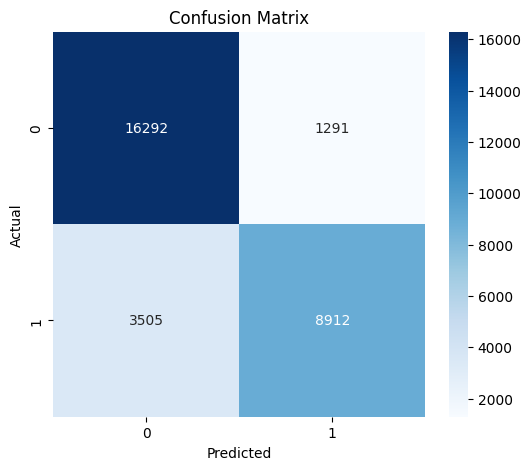

BATCH 4 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4162, Val Loss: 0.3336
Epoch 2/10, Train Loss: 0.3351, Val Loss: 0.2953
Epoch 3/10, Train Loss: 0.3001, Val Loss: 0.2648
Epoch 4/10, Train Loss: 0.2792, Val Loss: 0.2651
Epoch 5/10, Train Loss: 0.2512, Val Loss: 0.2340
Epoch 6/10, Train Loss: 0.2241, Val Loss: 0.2103
Epoch 7/10, Train Loss: 0.2155, Val Loss: 0.1900
Epoch 8/10, Train Loss: 0.1969, Val Loss: 0.1909
Epoch 9/10, Train Loss: 0.1956, Val Loss: 0.1846
Epoch 10/10, Train Loss: 0.1811, Val Loss: 0.1715
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8245
Confusion Matrix:
[[15911  1387]
 [ 3878  8824]]


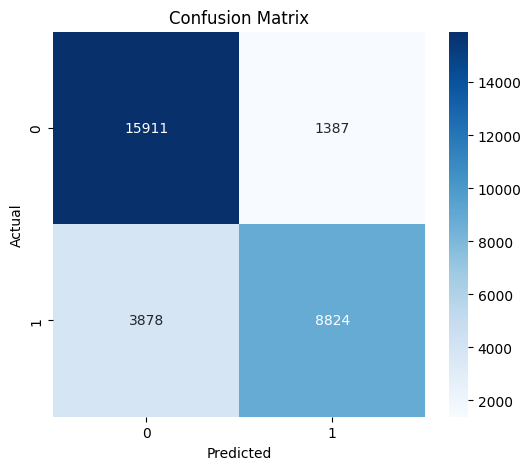

BATCH 5 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4063, Val Loss: 0.3291
Epoch 2/10, Train Loss: 0.3301, Val Loss: 0.2910
Epoch 3/10, Train Loss: 0.3013, Val Loss: 0.2656
Epoch 4/10, Train Loss: 0.2782, Val Loss: 0.2556
Epoch 5/10, Train Loss: 0.2580, Val Loss: 0.2304
Epoch 6/10, Train Loss: 0.2263, Val Loss: 0.2009
Epoch 7/10, Train Loss: 0.2232, Val Loss: 0.2038
Epoch 8/10, Train Loss: 0.2147, Val Loss: 0.1756
Epoch 9/10, Train Loss: 0.1850, Val Loss: 0.1643
Epoch 10/10, Train Loss: 0.1749, Val Loss: 0.1688
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8303
Confusion Matrix:
[[15081  1555]
 [ 3536  9828]]


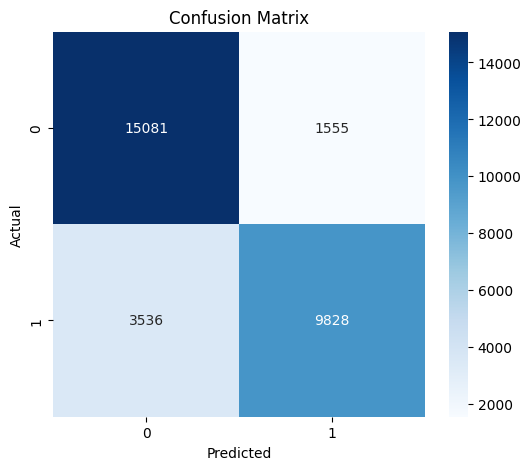

BATCH 6 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4283, Val Loss: 0.3506
Epoch 2/10, Train Loss: 0.3462, Val Loss: 0.3062
Epoch 3/10, Train Loss: 0.3081, Val Loss: 0.2673
Epoch 4/10, Train Loss: 0.2728, Val Loss: 0.2450
Epoch 5/10, Train Loss: 0.2495, Val Loss: 0.2213
Epoch 6/10, Train Loss: 0.2266, Val Loss: 0.2157
Epoch 7/10, Train Loss: 0.2149, Val Loss: 0.1872
Epoch 8/10, Train Loss: 0.2007, Val Loss: 0.1758
Epoch 9/10, Train Loss: 0.1775, Val Loss: 0.1976
Epoch 10/10, Train Loss: 0.1826, Val Loss: 0.1920
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8118
Confusion Matrix:
[[14610  1422]
 [ 4225  9743]]


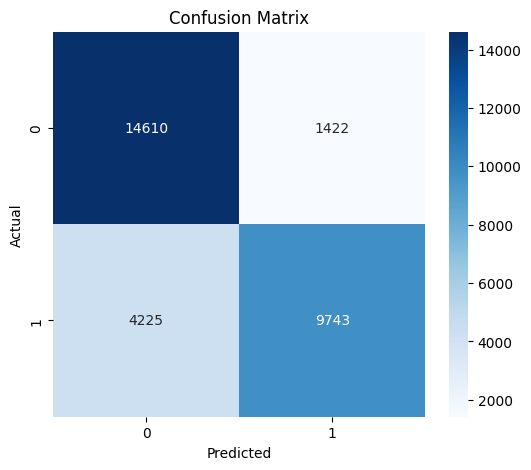

BATCH 7 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3939, Val Loss: 0.3226
Epoch 2/10, Train Loss: 0.3164, Val Loss: 0.2854
Epoch 3/10, Train Loss: 0.2792, Val Loss: 0.2551
Epoch 4/10, Train Loss: 0.2431, Val Loss: 0.2144
Epoch 5/10, Train Loss: 0.2234, Val Loss: 0.2025
Epoch 6/10, Train Loss: 0.1962, Val Loss: 0.1864
Epoch 7/10, Train Loss: 0.1910, Val Loss: 0.1786
Epoch 8/10, Train Loss: 0.1874, Val Loss: 0.1575
Epoch 9/10, Train Loss: 0.1594, Val Loss: 0.1409
Epoch 10/10, Train Loss: 0.1478, Val Loss: 0.1473
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8130
Confusion Matrix:
[[15241  1533]
 [ 4076  9150]]


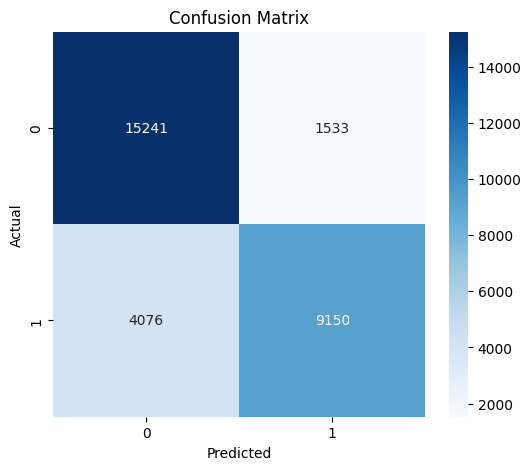

BATCH 8 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4069, Val Loss: 0.3210
Epoch 2/10, Train Loss: 0.3333, Val Loss: 0.2944
Epoch 3/10, Train Loss: 0.2956, Val Loss: 0.2732
Epoch 4/10, Train Loss: 0.2609, Val Loss: 0.2265
Epoch 5/10, Train Loss: 0.2307, Val Loss: 0.2105
Epoch 6/10, Train Loss: 0.2084, Val Loss: 0.1800
Epoch 7/10, Train Loss: 0.1895, Val Loss: 0.1689
Epoch 8/10, Train Loss: 0.1831, Val Loss: 0.1651
Epoch 9/10, Train Loss: 0.1759, Val Loss: 0.1566
Epoch 10/10, Train Loss: 0.1654, Val Loss: 0.1664
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8245
Confusion Matrix:
[[15575  1607]
 [ 3659  9159]]


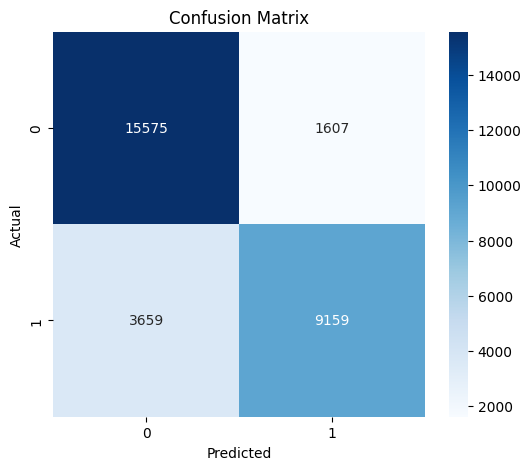

BATCH 9 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4047, Val Loss: 0.3144
Epoch 2/10, Train Loss: 0.3200, Val Loss: 0.2841
Epoch 3/10, Train Loss: 0.2835, Val Loss: 0.2436
Epoch 4/10, Train Loss: 0.2560, Val Loss: 0.2303
Epoch 5/10, Train Loss: 0.2292, Val Loss: 0.1993
Epoch 6/10, Train Loss: 0.2100, Val Loss: 0.1810
Epoch 7/10, Train Loss: 0.1934, Val Loss: 0.1905
Epoch 8/10, Train Loss: 0.1904, Val Loss: 0.1738
Epoch 9/10, Train Loss: 0.1735, Val Loss: 0.1459
Epoch 10/10, Train Loss: 0.1618, Val Loss: 0.1457
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8398
Confusion Matrix:
[[16005  1156]
 [ 3650  9189]]


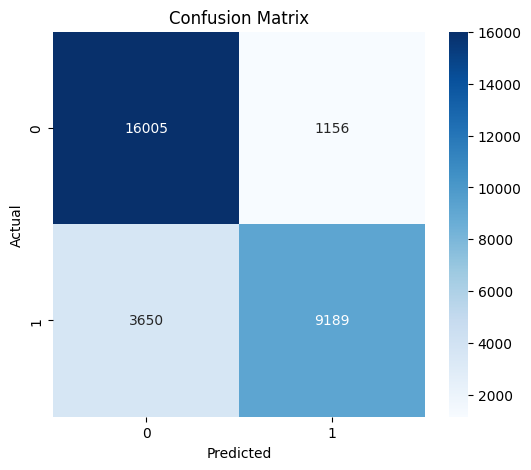

BATCH 10 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3778, Val Loss: 0.3043
Epoch 2/10, Train Loss: 0.2982, Val Loss: 0.2562
Epoch 3/10, Train Loss: 0.2702, Val Loss: 0.2369
Epoch 4/10, Train Loss: 0.2301, Val Loss: 0.1922
Epoch 5/10, Train Loss: 0.2025, Val Loss: 0.1817
Epoch 6/10, Train Loss: 0.1834, Val Loss: 0.1689
Epoch 7/10, Train Loss: 0.1869, Val Loss: 0.1559
Epoch 8/10, Train Loss: 0.1614, Val Loss: 0.1395
Epoch 9/10, Train Loss: 0.1530, Val Loss: 0.1357
Epoch 10/10, Train Loss: 0.1399, Val Loss: 0.1784
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8292
Confusion Matrix:
[[15528  1606]
 [ 3517  9349]]


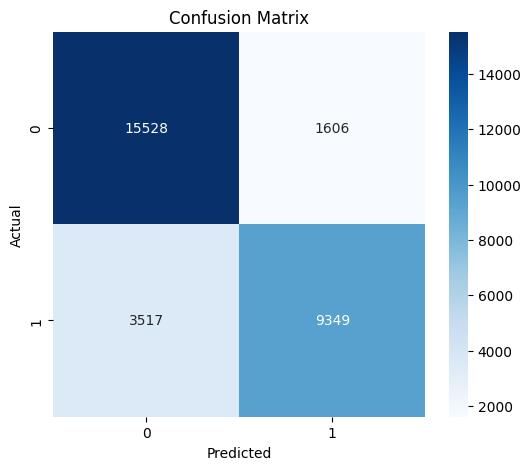

BATCH 11 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4166, Val Loss: 0.3306
Epoch 2/10, Train Loss: 0.3287, Val Loss: 0.2888
Epoch 3/10, Train Loss: 0.2920, Val Loss: 0.2531
Epoch 4/10, Train Loss: 0.2575, Val Loss: 0.2204
Epoch 5/10, Train Loss: 0.2379, Val Loss: 0.1983
Epoch 6/10, Train Loss: 0.2222, Val Loss: 0.2028
Epoch 7/10, Train Loss: 0.1970, Val Loss: 0.1924
Epoch 8/10, Train Loss: 0.1811, Val Loss: 0.1716
Epoch 9/10, Train Loss: 0.1687, Val Loss: 0.1660
Epoch 10/10, Train Loss: 0.1701, Val Loss: 0.1482
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8265
Confusion Matrix:
[[16140  1330]
 [ 3876  8654]]


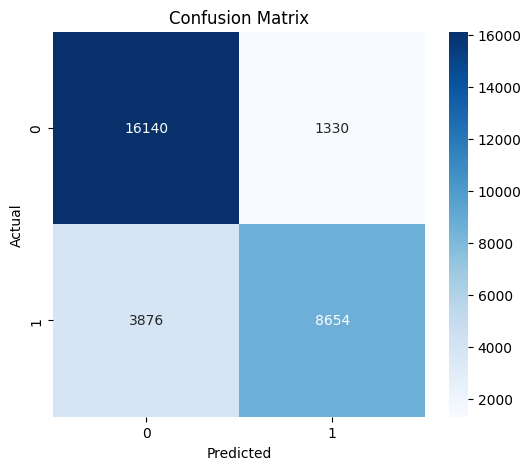

BATCH 12 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4065, Val Loss: 0.3000
Epoch 2/10, Train Loss: 0.2901, Val Loss: 0.2618
Epoch 3/10, Train Loss: 0.2592, Val Loss: 0.2226
Epoch 4/10, Train Loss: 0.2241, Val Loss: 0.1903
Epoch 5/10, Train Loss: 0.1913, Val Loss: 0.1801
Epoch 6/10, Train Loss: 0.1795, Val Loss: 0.1644
Epoch 7/10, Train Loss: 0.1689, Val Loss: 0.1534
Epoch 8/10, Train Loss: 0.1587, Val Loss: 0.1546
Epoch 9/10, Train Loss: 0.1549, Val Loss: 0.1220
Epoch 10/10, Train Loss: 0.1296, Val Loss: 0.1470
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8210
Confusion Matrix:
[[14848  1528]
 [ 3841  9783]]


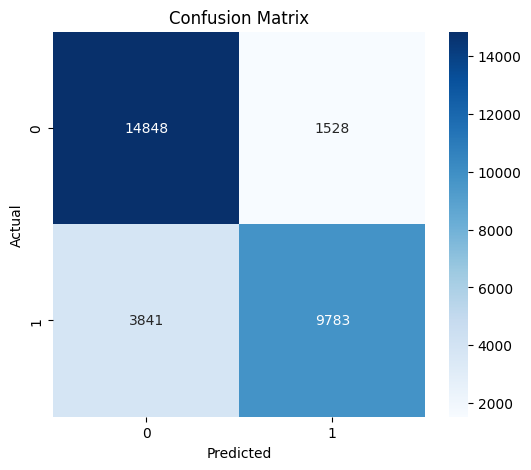

BATCH 13 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3908, Val Loss: 0.2943
Epoch 2/10, Train Loss: 0.2950, Val Loss: 0.2612
Epoch 3/10, Train Loss: 0.2585, Val Loss: 0.2158
Epoch 4/10, Train Loss: 0.2258, Val Loss: 0.2334
Epoch 5/10, Train Loss: 0.2068, Val Loss: 0.1821
Epoch 6/10, Train Loss: 0.1881, Val Loss: 0.1853
Epoch 7/10, Train Loss: 0.1708, Val Loss: 0.1636
Epoch 8/10, Train Loss: 0.1692, Val Loss: 0.1522
Epoch 9/10, Train Loss: 0.1639, Val Loss: 0.1476
Epoch 10/10, Train Loss: 0.1468, Val Loss: 0.1252
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8209
Confusion Matrix:
[[16060  1439]
 [ 3934  8567]]


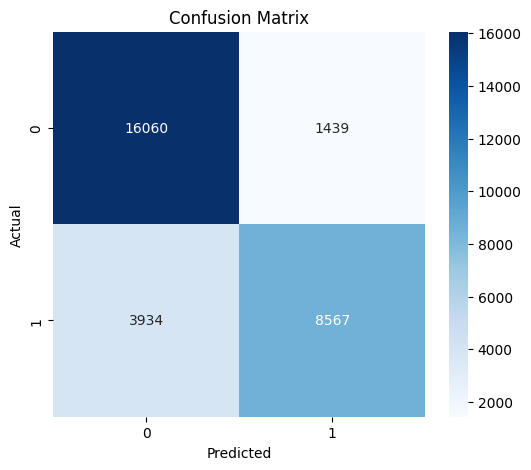

BATCH 14 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4184, Val Loss: 0.3075
Epoch 2/10, Train Loss: 0.3064, Val Loss: 0.2703
Epoch 3/10, Train Loss: 0.2715, Val Loss: 0.2320
Epoch 4/10, Train Loss: 0.2439, Val Loss: 0.2245
Epoch 5/10, Train Loss: 0.2214, Val Loss: 0.1816
Epoch 6/10, Train Loss: 0.1932, Val Loss: 0.1671
Epoch 7/10, Train Loss: 0.1730, Val Loss: 0.1903
Epoch 8/10, Train Loss: 0.1775, Val Loss: 0.1580
Epoch 9/10, Train Loss: 0.1571, Val Loss: 0.1611
Epoch 10/10, Train Loss: 0.1429, Val Loss: 0.1303
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8332
Confusion Matrix:
[[15866  1176]
 [ 3829  9129]]


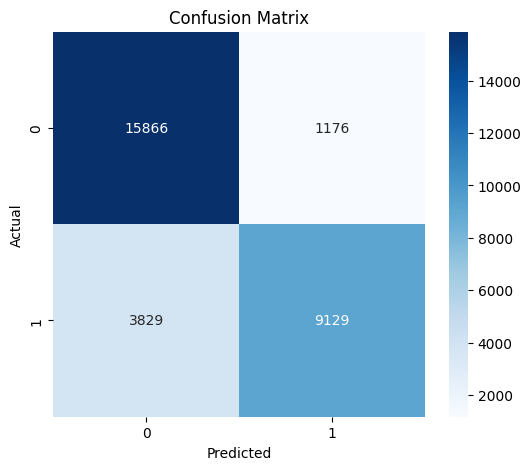

BATCH 15 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4358, Val Loss: 0.3256
Epoch 2/10, Train Loss: 0.3302, Val Loss: 0.2796
Epoch 3/10, Train Loss: 0.2881, Val Loss: 0.2482
Epoch 4/10, Train Loss: 0.2587, Val Loss: 0.2101
Epoch 5/10, Train Loss: 0.2225, Val Loss: 0.2046
Epoch 6/10, Train Loss: 0.1960, Val Loss: 0.1900
Epoch 7/10, Train Loss: 0.1884, Val Loss: 0.1634
Epoch 8/10, Train Loss: 0.1681, Val Loss: 0.1708
Epoch 9/10, Train Loss: 0.1588, Val Loss: 0.1319
Epoch 10/10, Train Loss: 0.1414, Val Loss: 0.1255
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8009
Confusion Matrix:
[[14828  1732]
 [ 4240  9200]]


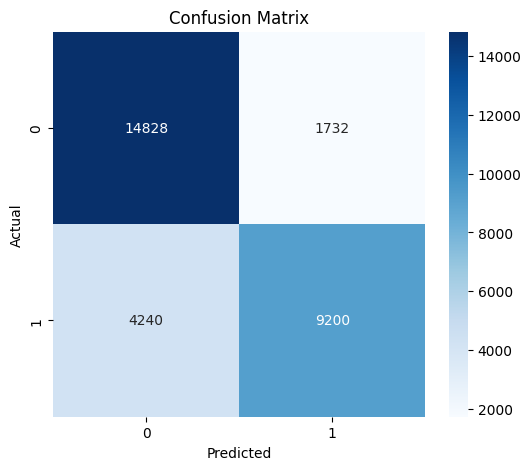

BATCH 16 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4422, Val Loss: 0.3145
Epoch 2/10, Train Loss: 0.3104, Val Loss: 0.2747
Epoch 3/10, Train Loss: 0.2778, Val Loss: 0.2400
Epoch 4/10, Train Loss: 0.2535, Val Loss: 0.2105
Epoch 5/10, Train Loss: 0.2157, Val Loss: 0.1932
Epoch 6/10, Train Loss: 0.1898, Val Loss: 0.1798
Epoch 7/10, Train Loss: 0.1883, Val Loss: 0.1753
Epoch 8/10, Train Loss: 0.1790, Val Loss: 0.1471
Epoch 9/10, Train Loss: 0.1600, Val Loss: 0.1432
Epoch 10/10, Train Loss: 0.1493, Val Loss: 0.1419
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8468
Confusion Matrix:
[[15974  1312]
 [ 3283  9431]]


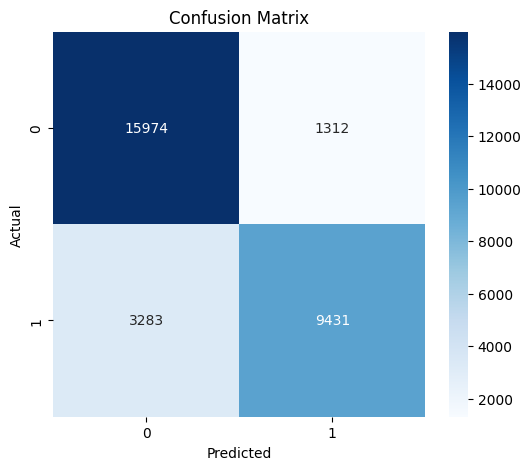

BATCH 17 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3965, Val Loss: 0.2951
Epoch 2/10, Train Loss: 0.2912, Val Loss: 0.2633
Epoch 3/10, Train Loss: 0.2543, Val Loss: 0.2174
Epoch 4/10, Train Loss: 0.2196, Val Loss: 0.1824
Epoch 5/10, Train Loss: 0.1900, Val Loss: 0.1764
Epoch 6/10, Train Loss: 0.1888, Val Loss: 0.1541
Epoch 7/10, Train Loss: 0.1638, Val Loss: 0.1606
Epoch 8/10, Train Loss: 0.1587, Val Loss: 0.1333
Epoch 9/10, Train Loss: 0.1421, Val Loss: 0.1205
Epoch 10/10, Train Loss: 0.1277, Val Loss: 0.1257
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8341
Confusion Matrix:
[[16741  1427]
 [ 3549  8283]]


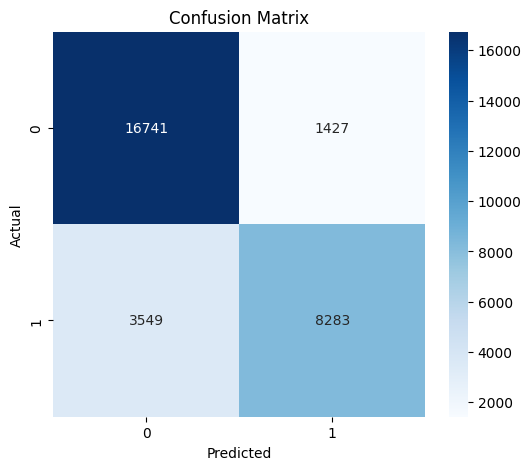

BATCH 18 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4106, Val Loss: 0.3163
Epoch 2/10, Train Loss: 0.3030, Val Loss: 0.2644
Epoch 3/10, Train Loss: 0.2662, Val Loss: 0.2242
Epoch 4/10, Train Loss: 0.2344, Val Loss: 0.1992
Epoch 5/10, Train Loss: 0.2128, Val Loss: 0.1769
Epoch 6/10, Train Loss: 0.1766, Val Loss: 0.1539
Epoch 7/10, Train Loss: 0.1687, Val Loss: 0.1593
Epoch 8/10, Train Loss: 0.1608, Val Loss: 0.1491
Epoch 9/10, Train Loss: 0.1531, Val Loss: 0.1342
Epoch 10/10, Train Loss: 0.1351, Val Loss: 0.1380
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8165
Confusion Matrix:
[[15841  1421]
 [ 4083  8655]]


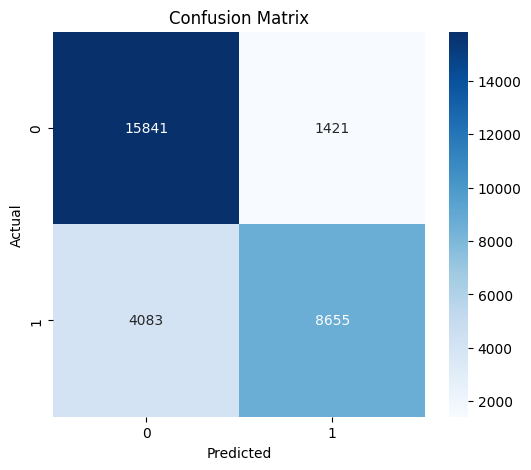

BATCH 19 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4245, Val Loss: 0.3111
Epoch 2/10, Train Loss: 0.3124, Val Loss: 0.2681
Epoch 3/10, Train Loss: 0.2792, Val Loss: 0.2336
Epoch 4/10, Train Loss: 0.2487, Val Loss: 0.2107
Epoch 5/10, Train Loss: 0.2267, Val Loss: 0.1954
Epoch 6/10, Train Loss: 0.1983, Val Loss: 0.1746
Epoch 7/10, Train Loss: 0.1792, Val Loss: 0.1615
Epoch 8/10, Train Loss: 0.1702, Val Loss: 0.1659
Epoch 9/10, Train Loss: 0.1674, Val Loss: 0.1493
Epoch 10/10, Train Loss: 0.1599, Val Loss: 0.1480
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8929
Confusion Matrix:
[[16330   402]
 [ 2810 10458]]


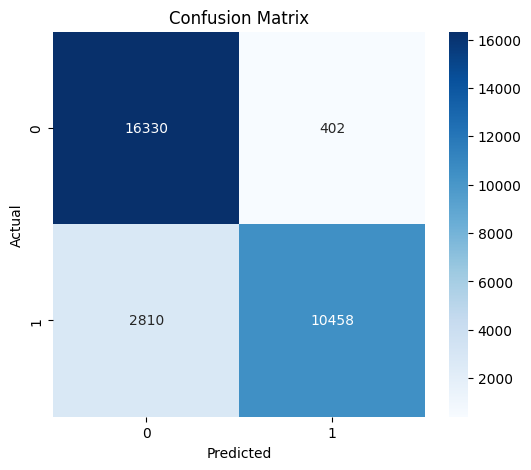

BATCH 20 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4095, Val Loss: 0.3084
Epoch 2/10, Train Loss: 0.3018, Val Loss: 0.2658
Epoch 3/10, Train Loss: 0.2631, Val Loss: 0.2233
Epoch 4/10, Train Loss: 0.2255, Val Loss: 0.1857
Epoch 5/10, Train Loss: 0.2021, Val Loss: 0.1820
Epoch 6/10, Train Loss: 0.1771, Val Loss: 0.1588
Epoch 7/10, Train Loss: 0.1603, Val Loss: 0.1443
Epoch 8/10, Train Loss: 0.1532, Val Loss: 0.1539
Epoch 9/10, Train Loss: 0.1563, Val Loss: 0.1354
Epoch 10/10, Train Loss: 0.1472, Val Loss: 0.1267
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8233
Confusion Matrix:
[[16383  1561]
 [ 3740  8316]]


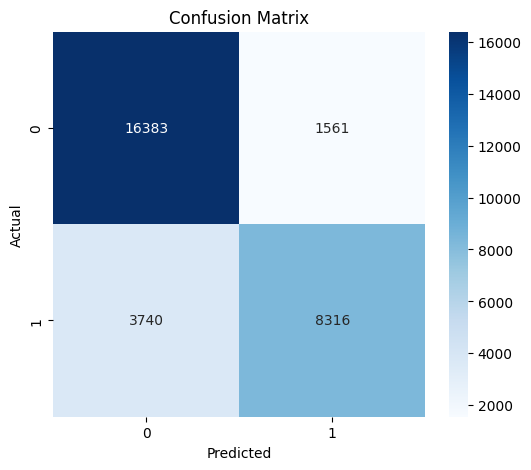

BATCH 21 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4255, Val Loss: 0.3090
Epoch 2/10, Train Loss: 0.3027, Val Loss: 0.2571
Epoch 3/10, Train Loss: 0.2677, Val Loss: 0.2501
Epoch 4/10, Train Loss: 0.2305, Val Loss: 0.2044
Epoch 5/10, Train Loss: 0.2080, Val Loss: 0.1800
Epoch 6/10, Train Loss: 0.1891, Val Loss: 0.1936
Epoch 7/10, Train Loss: 0.1821, Val Loss: 0.1523
Epoch 8/10, Train Loss: 0.1678, Val Loss: 0.1510
Epoch 9/10, Train Loss: 0.1584, Val Loss: 0.1636
Epoch 10/10, Train Loss: 0.1535, Val Loss: 0.1414
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8213
Confusion Matrix:
[[16186  1654]
 [ 3708  8452]]


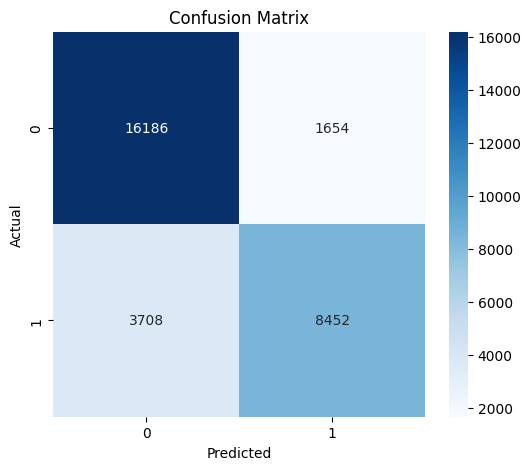

BATCH 22 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4445, Val Loss: 0.3310
Epoch 2/10, Train Loss: 0.3215, Val Loss: 0.2754
Epoch 3/10, Train Loss: 0.2793, Val Loss: 0.2470
Epoch 4/10, Train Loss: 0.2533, Val Loss: 0.2203
Epoch 5/10, Train Loss: 0.2264, Val Loss: 0.2024
Epoch 6/10, Train Loss: 0.2084, Val Loss: 0.2053
Epoch 7/10, Train Loss: 0.2028, Val Loss: 0.1726
Epoch 8/10, Train Loss: 0.1728, Val Loss: 0.1699
Epoch 9/10, Train Loss: 0.1607, Val Loss: 0.1497
Epoch 10/10, Train Loss: 0.1644, Val Loss: 0.1496
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8113
Confusion Matrix:
[[15647  1417]
 [ 4243  8693]]


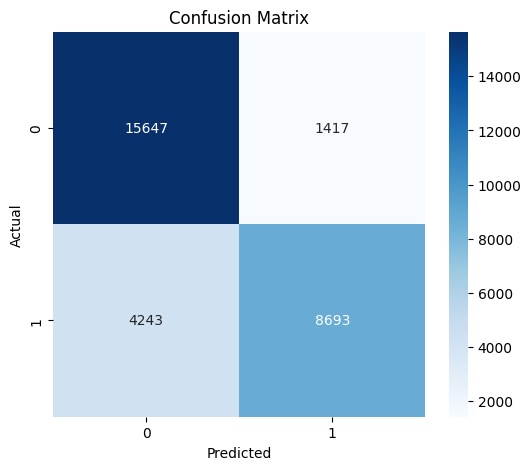

BATCH 23 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4239, Val Loss: 0.3113
Epoch 2/10, Train Loss: 0.3145, Val Loss: 0.2662
Epoch 3/10, Train Loss: 0.2771, Val Loss: 0.2374
Epoch 4/10, Train Loss: 0.2376, Val Loss: 0.2188
Epoch 5/10, Train Loss: 0.2157, Val Loss: 0.2117
Epoch 6/10, Train Loss: 0.1912, Val Loss: 0.1757
Epoch 7/10, Train Loss: 0.1779, Val Loss: 0.1605
Epoch 8/10, Train Loss: 0.1775, Val Loss: 0.1572
Epoch 9/10, Train Loss: 0.1705, Val Loss: 0.1637
Epoch 10/10, Train Loss: 0.1605, Val Loss: 0.1386
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8298
Confusion Matrix:
[[15325  1669]
 [ 3438  9568]]


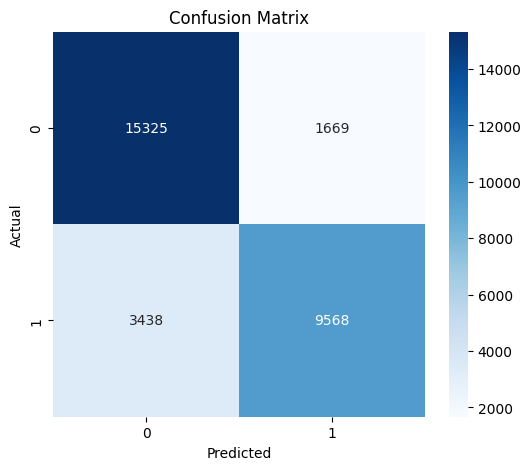

BATCH 24 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4483, Val Loss: 0.3299
Epoch 2/10, Train Loss: 0.3226, Val Loss: 0.2751
Epoch 3/10, Train Loss: 0.2792, Val Loss: 0.2332
Epoch 4/10, Train Loss: 0.2427, Val Loss: 0.2220
Epoch 5/10, Train Loss: 0.2148, Val Loss: 0.1902
Epoch 6/10, Train Loss: 0.1958, Val Loss: 0.1792
Epoch 7/10, Train Loss: 0.1798, Val Loss: 0.1612
Epoch 8/10, Train Loss: 0.1619, Val Loss: 0.1644
Epoch 9/10, Train Loss: 0.1715, Val Loss: 0.1647
Epoch 10/10, Train Loss: 0.1635, Val Loss: 0.1509
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8320
Confusion Matrix:
[[15776  1176]
 [ 3864  9184]]


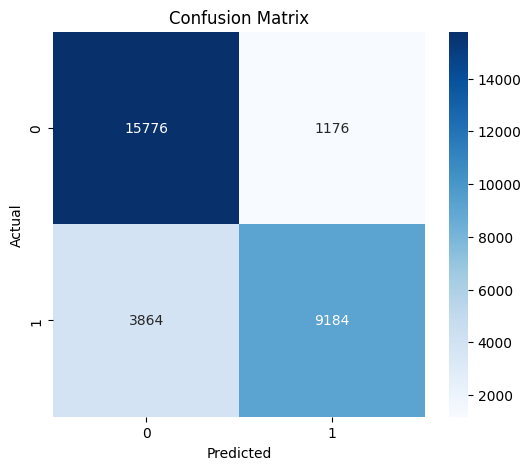

BATCH 25 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4321, Val Loss: 0.3219
Epoch 2/10, Train Loss: 0.3231, Val Loss: 0.2772
Epoch 3/10, Train Loss: 0.2804, Val Loss: 0.2413
Epoch 4/10, Train Loss: 0.2485, Val Loss: 0.2198
Epoch 5/10, Train Loss: 0.2242, Val Loss: 0.2202
Epoch 6/10, Train Loss: 0.1996, Val Loss: 0.1732
Epoch 7/10, Train Loss: 0.1839, Val Loss: 0.1832
Epoch 8/10, Train Loss: 0.1883, Val Loss: 0.1672
Epoch 9/10, Train Loss: 0.1740, Val Loss: 0.1706
Epoch 10/10, Train Loss: 0.1627, Val Loss: 0.1440
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8255
Confusion Matrix:
[[16792  1339]
 [ 3896  7973]]


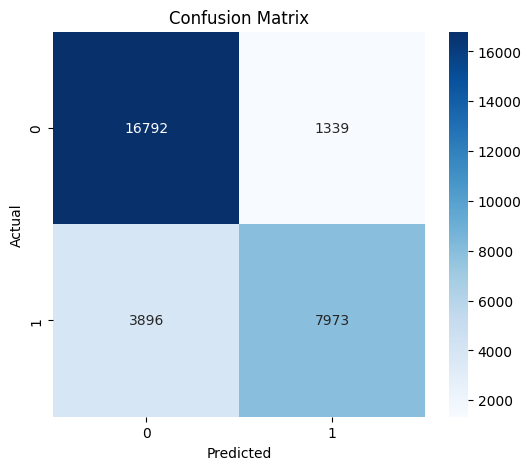

BATCH 26 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4133, Val Loss: 0.3048
Epoch 2/10, Train Loss: 0.3047, Val Loss: 0.2561
Epoch 3/10, Train Loss: 0.2692, Val Loss: 0.2289
Epoch 4/10, Train Loss: 0.2331, Val Loss: 0.1954
Epoch 5/10, Train Loss: 0.2053, Val Loss: 0.1747
Epoch 6/10, Train Loss: 0.1877, Val Loss: 0.1797
Epoch 7/10, Train Loss: 0.1812, Val Loss: 0.1842
Epoch 8/10, Train Loss: 0.1762, Val Loss: 0.1613
Epoch 9/10, Train Loss: 0.1639, Val Loss: 0.1432
Epoch 10/10, Train Loss: 0.1393, Val Loss: 0.1413
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8347
Confusion Matrix:
[[16095  1517]
 [ 3442  8946]]


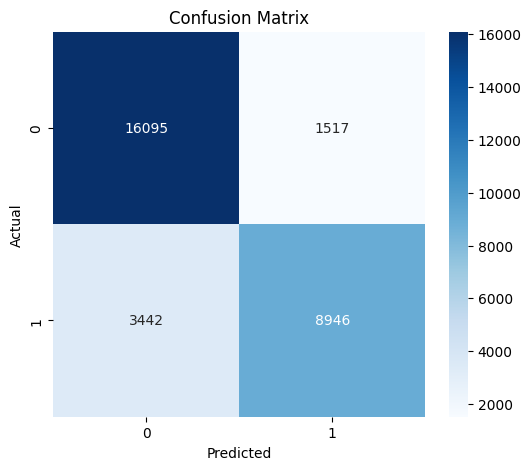

BATCH 27 out of TOTAL: 27 completed


/var/folders/yx/sfg6zx2j1vn7xb7bkfy_g_900000gn/T/ipykernel_3044/2667612721.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4629, Val Loss: 0.3395
Epoch 2/10, Train Loss: 0.3316, Val Loss: 0.2844
Epoch 3/10, Train Loss: 0.2940, Val Loss: 0.2491
Epoch 4/10, Train Loss: 0.2533, Val Loss: 0.2150
Epoch 5/10, Train Loss: 0.2276, Val Loss: 0.2006
Epoch 6/10, Train Loss: 0.1938, Val Loss: 0.1852
Epoch 7/10, Train Loss: 0.1918, Val Loss: 0.1838
Epoch 8/10, Train Loss: 0.1784, Val Loss: 0.1495
Epoch 9/10, Train Loss: 0.1624, Val Loss: 0.1408
Epoch 10/10, Train Loss: 0.1467, Val Loss: 0.1562
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8153
Confusion Matrix:
[[14734  1669]
 [ 3873  9724]]


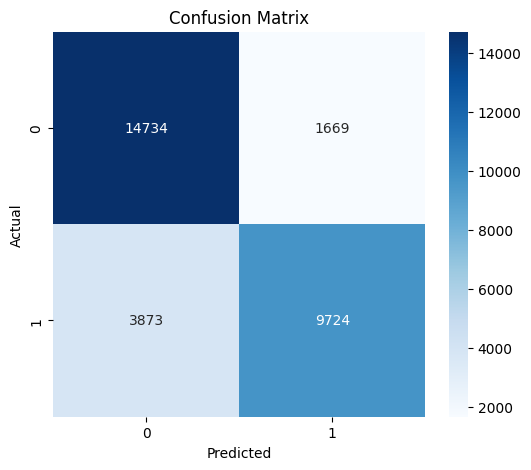

BATCH 28 out of TOTAL: 27 completed
Training Completed


In [12]:
import numpy as np

batch = 0
batch_file_size = 1000
total = int(len(file_df)/batch_file_size)
model = VAPModel()


for i in range(0, len(file_df)-batch_file_size, batch_file_size):

    ## Training ##
    train_files = file_df['file_paths'][i: i+batch_file_size]
    training_data = extract_mfcc_features(train_files)
    train_model(model, training_data, batch_size=16, epochs=10, seq_length=100)

    ## Evaluation
    random_integer = np.random.randint(1, len(file_df)- batch_file_size)
    eval_files = file_df['file_paths'][random_integer: random_integer + 300]
    eval_data = extract_mfcc_features(eval_files)
    eval_dataset = VAPDataset(eval_data)
    eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=True)
    evaluate_model(model, eval_dataloader, output_file=LOG_MODEL_EVALUATION, metrics_file=LOG_MODEL_PREDICTION)

    batch += 1
    print(f"BATCH {batch} out of TOTAL: {total} completed")

print("Training Completed")
    